***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,Target,url_char_%,url_char_&,url_char_+,url_char_-,url_char_.,url_char_/,url_char_0,url_char_1,url_char_2,url_char_3,url_char_4,url_char_5,url_char_6,url_char_7,url_char_8,url_char_9,url_char_:,url_char_=,url_char_?,url_char_A,url_char_B,url_char_C,url_char_D,url_char_E,url_char_F,url_char_G,url_char_H,url_char_I,url_char_J,url_char_K,url_char_L,url_char_M,url_char_N,url_char_O,url_char_P,url_char_Q,url_char_R,url_char_S,url_char_T,url_char_U,url_char_V,url_char_W,url_char_X,url_char_Y,url_char_Z,url_char__,url_char_a,url_char_b,url_char_c,url_char_d,url_char_e,url_char_f,url_char_g,url_char_h,url_char_i,url_char_j,url_char_k,url_char_l,url_char_m,url_char_n,url_char_o,url_char_p,url_char_q,url_char_r,url_char_s,url_char_t,url_char_u,url_char_v,url_char_w,url_char_x,url_char_y,url_char_z,url_contains_ip,url_contains_signin,url_contains_www,url_extension_.a,url_extension_.acc,url_extension_.ad,url_extension_.ag,url_extension_.ai,url_extension_.ap,url_extension_.app,url_extension_.asi,url_extension_.au,url_extension_.b,url_extension_.ban,url_extension_.bid,url_extension_.bik,url_extension_.br,url_extension_.c,url_extension_.ca,url_extension_.car,url_extension_.cat,url_extension_.cc,url_extension_.ce,url_extension_.cf,url_extension_.ch,url_extension_.cit,url_extension_.cl,url_extension_.class,url_extension_.cli,url_extension_.com,url_extension_.con,url_extension_.cur,url_extension_.d,url_extension_.dat,url_extension_.de,url_extension_.dec,url_extension_.dis,url_extension_.do,url_extension_.ex,url_extension_.exe,url_extension_.f,url_extension_.fgd,url_extension_.fi,url_extension_.fin,url_extension_.fm,url_extension_.fre,url_extension_.g,url_extension_.gg,url_extension_.gl,url_extension_.gra,url_extension_.h,url_extension_.ha,url_extension_.htm,url_extension_.html,url_extension_.i,url_extension_.icl,url_extension_.id,url_extension_.imp,url_extension_.inf,url_extension_.int,url_extension_.io,url_extension_.it,url_extension_.jpg,url_extension_.l,url_extension_.lid,url_extension_.lif,url_extension_.lin,url_extension_.log,url_extension_.m,url_extension_.man,url_extension_.me,url_extension_.med,url_extension_.mk,url_extension_.mm,url_extension_.mmo,url_extension_.mob,url_extension_.mon,url_extension_.mu,url_extension_.mus,url_extension_.net,url_extension_.new,url_extension_.ng,url_extension_.o,url_extension_.one,url_extension_.org,url_extension_.p,url_extension_.pa,url_extension_.par,url_extension_.ph,url_extension_.php,url_extension_.pip,url_extension_.pit,url_extension_.pk,url_extension_.pl,url_extension_.png,url_extension_.pp,url_extension_.pre,url_extension_.pri,url_extension_.pro,url_extension_.pw,url_extension_.r,url_extension_.ra,url_extension_.res,url_extension_.rev,url_extension_.ri,url_extension_.rs,url_extension_.ru,url_extension_.s,url_extension_.sc,url_extension_.sca,url_extension_.sci,url_extension_.sec,url_extension_.sf,url_extension_.sfl,url_extension_.sh,url_extension_.sha,url_extension_.sit,url_extension_.so,url_extension_.sp,url_extension_.spa,url_extension_.st,url_extension_.sta,url_extension_.sto,url_extension_.str,url_extension_.sup,url_extension_.t,url_extension_.tr,url_extension_.tv,url_extension_.upd,url_extension_.v,url_extension_.ver,url_extension_.vgr,url_extension_.vi,url_extension_.vic,url_extension_.vid,url_extension_.vo,url_extension_.w,url_extension_.web,url_extension_.win,url_extension_.wor,url_extension_.ws,url_extension_.x,url_extension_.xi,url_extension_.xx,url_extension_.xxx,url_extension_.xy,url_extension_.xyz,url_extension_.y,url_extension_.z,url_extension_.zi,url_extension_.zon,url_extension_0,url_extension_0.1,url_extension_0.8,url_extension_endswith_.a,url_extension_endswith_.acc,url_extension_endswith_.ad,url_extension_endswith_.ag,url_extension_endswith_.ai,url_extension_endswith_.ap,url_extension_endswith_.app,url_extension_endswith_.asi,url_extension_endswith_.au,url_extension_endswith_.b,url_extension_endswith_.ban,url_extension_endswith_.bid,url_extension_endswith_.bik,url_extension_ends

Shape of our dataset: (46771, 4194)


In [6]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [7]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
display(np.array(col_no_unique))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

302 columns have only one unique value in them rendering them meaningless for classification


array(['url_contains_ip', 'url_extension_endswith_.a',
       'url_extension_endswith_.acc', 'url_extension_endswith_.ap',
       'url_extension_endswith_.asi', 'url_extension_endswith_.b',
       'url_extension_endswith_.ban', 'url_extension_endswith_.bik',
       'url_extension_endswith_.c', 'url_extension_endswith_.car',
       'url_extension_endswith_.ce', 'url_extension_endswith_.cit',
       'url_extension_endswith_.cli', 'url_extension_endswith_.con',
       'url_extension_endswith_.cur', 'url_extension_endswith_.d',
       'url_extension_endswith_.dec', 'url_extension_endswith_.dis',
       'url_extension_endswith_.ex', 'url_extension_endswith_.f',
       'url_extension_endswith_.fgd', 'url_extension_endswith_.fin',
       'url_extension_endswith_.fre', 'url_extension_endswith_.g',
       'url_extension_endswith_.gra', 'url_extension_endswith_.h',
       'url_extension_endswith_.ha', 'url_extension_endswith_.i',
       'url_extension_endswith_.icl', 'url_extension_endswith_.imp

Shape of our dataset after dropping them: (46771, 3892)


In [8]:
ext_end=[col for col in df.columns if 'extension_ends' in col]

for col in ext_end:
    df[col]=df[col].astype(int)

# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
print("Columns which are of type object:\n",df.dtypes[(df.dtypes=='object')])

Columns which are of type object:
 url_contains_signin    object
url_contains_www       object
url_host               object
url_ip                 object
dtype: object


In [9]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

3845 columns have more than 95% same values


In [10]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
col_values['95_%_same_values'].value_counts()

True     3845
False      46
Name: 95_%_same_values, dtype: int64

In [11]:
print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])
columns.remove('url_host')

Columns which are of type object: url_host    object
dtype: object


In [12]:
rem=['url_tld_NET','url_tld_COM','url_tld_NE','url_tld_CO','url_extension_endswith_.com', 'url_extension_.c']
for col in rem:
    columns.remove(col)

In [13]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
url_extension_.com,-0.154316,4.061880e-247,-34.113589,9.926271e-241
url_extension_.i,-0.005769,2.122020e-01,-1.243880,2.135748e-01
url_char_m,-0.000765,8.685861e-01,-0.133716,8.936303e-01
url_char_o,0.074650,8.715169e-59,12.338724,1.155801e-34
url_char_j,0.116675,1.984745e-141,16.725416,1.082992e-61
url_char_v,0.105337,1.682865e-115,17.027650,6.949488e-64
url_char_c,0.110988,4.385017e-128,17.136575,1.205077e-64
url_char_g,0.119543,2.045127e-148,20.120991,6.796065e-88
url_char_-,0.188291,0.000000e+00,22.532080,1.071961e-108



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
url_extension_.net,138.8931,0.0,0.0545


In [20]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [21]:
fin_col=columns
fin_col

['Target',
 'url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [16]:
columns.remove('Target')

In [17]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [18]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.962958013737
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31809    83    31892
True        1303  4222     5525
__all__    33112  4305    37417

Accuracy of the model for test data is: 0.957130639299
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7957    28     7985
True         373   996     1369
__all__     8330  1024     9354



Logistic Regression
Accuracy of the model for training data is: 0.950771039902
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31480   412    31892
True        1430  4095     5525
__all__    32910  4507    37417

Accuracy of the model for test data is: 0.95082317725
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7865   120     7985
True         340  1029     1369
__all__     8205  1149     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994735013497
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     8    31892
True         189  5336     5525
__all__    32073  5344    37417

Accuracy of the model for test data is: 0.963545007483
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7931    54     7985
True         287  1082     1369
__all__     8218  1136     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.946200924713
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31429   463    31892
True        1550  3975     5525
__all__    32979  4438    37417

Accuracy of the model for test data is: 0.945050245884
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7852   133     7985
True         381   988     1369
__all__     8233  1121     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.959510382981
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31543   349    31892
True        1166  4359     5525
__all__    32709  4708    37417

Accuracy of the model for test data is: 0.9594825743
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7894    91     7985
True         288  1081     1369
__all__     8182  1172     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.964079538165
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7942    43     7985
True         293  1076     1369
__all__     8235  1119     9354



Bagging Classifier
Accuracy of the model for training data is: 0.994093593821
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31883     9    31892
True         212  5313     5525
__all__    32095  5322    37417

Accuracy of the model for test data is: 0.962475946119
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7904    81     7985
True         270  1099     1369
__all__     8174  1180     9354



Neural Network-1
The accuracy of the model on training data is: 0.996445465965


Predicted  False  True  __all__
Actual                         
False      31877    15    31892
True         118  5407     5525
__all__    31995  5422    37417

The accuracy of the model on test data is: 0.955740859525


Predicted  False  True  __all__
Actual                         
False       7817   168     7985
True         246  1123     1369
__all__     8063  1291     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [19]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [20]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.962958,4222.0,31809.0,83.0,1303.0,0.002603,0.235837
LogisticRegression,0.950771,4095.0,31480.0,412.0,1430.0,0.012919,0.258824
RandomForestClassifier,0.994735,5336.0,31884.0,8.0,189.0,0.000251,0.034208
AdaBoostClassifier,0.946201,3975.0,31429.0,463.0,1550.0,0.014518,0.280543
GradientBoostingClassifier,0.959510,4359.0,31543.0,349.0,1166.0,0.010943,0.211041
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.994094,5313.0,31883.0,9.0,212.0,0.000282,0.038371
Neural Network-1,0.996445,5407.0,31877.0,15.0,118.0,0.000470,0.021357


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.957131,996.0,7957.0,28.0,373.0,0.003507,0.272462,0.862016,0.819642
LogisticRegression,0.950823,1029.0,7865.0,120.0,340.0,0.015028,0.248356,0.868308,0.793196
RandomForestClassifier,0.963545,1082.0,7931.0,54.0,287.0,0.006763,0.209642,0.891798,0.847928
AdaBoostClassifier,0.945050,988.0,7852.0,133.0,381.0,0.016656,0.278305,0.852519,0.767309
GradientBoostingClassifier,0.959483,1081.0,7894.0,91.0,288.0,0.011396,0.210373,0.889116,0.830910
ExtraTreeClassifier,0.964080,1076.0,7942.0,43.0,293.0,0.005385,0.214025,0.890295,0.850189
BaggingClassifier,0.962476,1099.0,7904.0,81.0,270.0,0.010144,0.197224,0.896316,0.843825
Neural Network-1,0.955741,1123.0,7817.0,168.0,246.0,0.021039,0.179693,0.896316,0.819068


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [21]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [22]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [23]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [24]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.976247961871
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30401   1491    31892
True          24  31868    31892
__all__    30425  33359    63784

Accuracy of the model for test data is: 0.917361556553
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7398   587     7985
True         186  1183     1369
__all__     7584  1770     9354



Logistic Regression
Accuracy of the model for training data is: 0.894754170325
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29567   2325    31892
True        4388  27504    31892
__all__    33955  29829    63784

Accuracy of the model for test data is: 0.917896087235
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7385   600     7985
True         168  1201     1369
__all__     7553  1801     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.99777373636
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31882     10    31892
True         132  31760    31892
__all__    32014  31770    63784

Accuracy of the model for test data is: 0.962582852256
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7899    86     7985
True         264  1105     1369
__all__     8163  1191     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.937021823655
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30378   1514    31892
True        2503  29389    31892
__all__    32881  30903    63784

Accuracy of the model for test data is: 0.929228137695
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7570   415     7985
True         247  1122     1369
__all__     7817  1537     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.965320456541
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31093    799    31892
True        1413  30479    31892
__all__    32506  31278    63784

Accuracy of the model for test data is: 0.94815052384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7749   236     7985
True         249  1120     1369
__all__     7998  1356     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999984322087
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31892      0    31892
True           1  31891    31892
__all__    31893  31891    63784

Accuracy of the model for test data is: 0.963010476801
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7910    75     7985
True         271  1098     1369
__all__     8181  1173     9354



Bagging Classifier
Accuracy of the model for training data is: 0.996989840712
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31878     14    31892
True         178  31714    31892
__all__    32056  31728    63784

Accuracy of the model for test data is: 0.958520419072
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7862   123     7985
True         265  1104     1369
__all__     8127  1227     9354



Neural Network-1
The accuracy of the model on training data is: 0.997428822275


Predicted  False   True  __all__
Actual                          
False      31802     90    31892
True          74  31818    31892
__all__    31876  31908    63784

The accuracy of the model on test data is: 0.944729527475


Predicted  False  True  __all__
Actual                         
False       7711   274     7985
True         243  1126     1369
__all__     7954  1400     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.976248,31868.0,30401.0,1491.0,24.0,0.046752,0.000753
LogisticRegression,0.894754,27504.0,29567.0,2325.0,4388.0,0.072902,0.137589
RandomForestClassifier,0.997774,31760.0,31882.0,10.0,132.0,0.000314,0.004139
AdaBoostClassifier,0.937022,29389.0,30378.0,1514.0,2503.0,0.047473,0.078484
GradientBoostingClassifier,0.965320,30479.0,31093.0,799.0,1413.0,0.025053,0.044306
ExtraTreeClassifier,0.999984,31891.0,31892.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.996990,31714.0,31878.0,14.0,178.0,0.000439,0.005581
Neural Network-1,0.997429,31818.0,31802.0,90.0,74.0,0.002822,0.002320


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.917362,1183.0,7398.0,587.0,186.0,0.073513,0.135866,0.895311,0.713464
LogisticRegression,0.917896,1201.0,7385.0,600.0,168.0,0.075141,0.122717,0.901071,0.719074
RandomForestClassifier,0.962583,1105.0,7899.0,86.0,264.0,0.010770,0.192841,0.898194,0.844468
AdaBoostClassifier,0.929228,1122.0,7570.0,415.0,247.0,0.051972,0.180424,0.883802,0.732183
GradientBoostingClassifier,0.948151,1120.0,7749.0,236.0,249.0,0.029555,0.181885,0.894280,0.791687
ExtraTreeClassifier,0.963010,1098.0,7910.0,75.0,271.0,0.009393,0.197955,0.896326,0.845999
BaggingClassifier,0.958520,1104.0,7862.0,123.0,265.0,0.015404,0.193572,0.895512,0.828212
Neural Network-1,0.944730,1126.0,7711.0,274.0,243.0,0.034314,0.177502,0.895512,0.780926


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [28]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 38)


In [29]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [30]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.916832579186
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5408   117     5525
True         802  4723     5525
__all__     6210  4840    11050

Accuracy of the model for test data is: 0.945584776566
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7725   260     7985
True         249  1120     1369
__all__     7974  1380     9354



Logistic Regression
Accuracy of the model for training data is: 0.900271493213
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5156   369     5525
True         733  4792     5525
__all__     5889  5161    11050

Accuracy of the model for test data is: 0.918858242463
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7396   589     7985
True         170  1199     1369
__all__     7566  1788     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.989411764706
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5516     9     5525
True         108  5417     5525
__all__     5624  5426    11050

Accuracy of the model for test data is: 0.933932007697
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7547   438     7985
True         180  1189     1369
__all__     7727  1627     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.894117647059
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5053   472     5525
True         698  4827     5525
__all__     5751  5299    11050

Accuracy of the model for test data is: 0.901325636092
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7228   757     7985
True         166  1203     1369
__all__     7394  1960     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.907692307692
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5232   293     5525
True         727  4798     5525
__all__     5959  5091    11050

Accuracy of the model for test data is: 0.926127859739
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7471   514     7985
True         177  1192     1369
__all__     7648  1706     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999909502262
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           1  5524     5525
__all__     5526  5524    11050

Accuracy of the model for test data is: 0.937566816335
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7580   405     7985
True         179  1190     1369
__all__     7759  1595     9354



Bagging Classifier
Accuracy of the model for training data is: 0.990678733032
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5520     5     5525
True          98  5427     5525
__all__     5618  5432    11050

Accuracy of the model for test data is: 0.931686978833
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7523   462     7985
True         177  1192     1369
__all__     7700  1654     9354



Neural Network-1
The accuracy of the model on training data is: 0.997647058824


Predicted  False  True  __all__
Actual                         
False       5520     5     5525
True          21  5504     5525
__all__     5541  5509    11050

The accuracy of the model on test data is: 0.896514859953


Predicted  False  True  __all__
Actual                         
False       7174   811     7985
True         157  1212     1369
__all__     7331  2023     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [31]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [32]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.916833,4723.0,5408.0,117.0,802.0,0.021176,0.145158
LogisticRegression,0.900271,4792.0,5156.0,369.0,733.0,0.066787,0.132670
RandomForestClassifier,0.989412,5417.0,5516.0,9.0,108.0,0.001629,0.019548
AdaBoostClassifier,0.894118,4827.0,5053.0,472.0,698.0,0.085430,0.126335
GradientBoostingClassifier,0.907692,4798.0,5232.0,293.0,727.0,0.053032,0.131584
ExtraTreeClassifier,0.999910,5524.0,5525.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.990679,5427.0,5520.0,5.0,98.0,0.000905,0.017738
Neural Network-1,0.997647,5504.0,5520.0,5.0,21.0,0.000905,0.003801


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.945585,1120.0,7725.0,260.0,249.0,0.032561,0.181885,0.892777,0.782957
LogisticRegression,0.918858,1199.0,7396.0,589.0,170.0,0.073763,0.124178,0.901029,0.720988
RandomForestClassifier,0.933932,1189.0,7547.0,438.0,180.0,0.054853,0.131483,0.906832,0.758726
AdaBoostClassifier,0.901326,1203.0,7228.0,757.0,166.0,0.094803,0.121256,0.891970,0.680855
GradientBoostingClassifier,0.926128,1192.0,7471.0,514.0,177.0,0.064371,0.129291,0.903169,0.738062
ExtraTreeClassifier,0.937567,1190.0,7580.0,405.0,179.0,0.050720,0.130752,0.909264,0.769289
BaggingClassifier,0.931687,1192.0,7523.0,462.0,177.0,0.057858,0.129291,0.906425,0.753072
Neural Network-1,0.896515,1212.0,7174.0,811.0,157.0,0.101565,0.114682,0.906425,0.672881


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [33]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [18]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [21]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2850 features
EntitySet scattered to workers in 4.549 seconds
Elapsed: 00:18 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [34]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

Built 2850 features
EntitySet scattered to workers in 5.002 seconds
Elapsed: 00:19 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [35]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [36]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [37]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [38]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [39]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [40]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [41]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 32)

In [42]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_. + url_char_w',
 'url_length + url_words_with_length_6',
 'url_length + url_words_with_length_5',
 'url_length + url_tlds',
 'url_length',
 'url_extensions + url_length',
 'url_extension_.net + url_length',
 'url_extension_.com + url_length',
 'url_char_y + url_length',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_z',
 'url_char_w + url_char_y',
 'url_char_w * url_extensions',
 'url_char_u + url_length',
 'url_char_p + url_length',
 'url_char_l + url_length',
 'url_char_k + url_length',
 'url_char_k + url_extensions',
 'url_char_j + url_length',
 'url_char_g + url_length',
 'url_char_e + url_length',
 'url_char_b + url_length',
 'url_char_a + url_length',
 'url_char_. + url_length',
 'url_char_. + url_extension_.net',
 'url_char_. + url_extension_.i',
 'url_char_. + url_char_z',
 'url_char_. + url_char_h',
 'url_char_. * url_char_w',
 'url_char_.',
 'url_char_- + url_length']

In [43]:
fs=fs.reindex(df_sel.index.values)

In [44]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [45]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [46]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.960098351017
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31512   380    31892
True        1113  4412     5525
__all__    32625  4792    37417

Accuracy of the model for test data is: 0.952426769297
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7849   136     7985
True         309  1060     1369
__all__     8158  1196     9354



Logistic Regression
Accuracy of the model for training data is: 0.942085148462
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31425   467    31892
True        1700  3825     5525
__all__    33125  4292    37417

Accuracy of the model for test data is: 0.941736155655
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7860   125     7985
True         420   949     1369
__all__     8280  1074     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.992089157335
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31865    27    31892
True         269  5256     5525
__all__    32134  5283    37417

Accuracy of the model for test data is: 0.952640581569
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7852   133     7985
True         310  1059     1369
__all__     8162  1192     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.938396985328
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31356   536    31892
True        1769  3756     5525
__all__    33125  4292    37417

Accuracy of the model for test data is: 0.93681847338
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7833   152     7985
True         439   930     1369
__all__     8272  1082     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.948953684154
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31402   490    31892
True        1420  4105     5525
__all__    32822  4595    37417

Accuracy of the model for test data is: 0.94665383793
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7853   132     7985
True         367  1002     1369
__all__     8220  1134     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.997514498757
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True          93  5432     5525
__all__    31985  5432    37417

Accuracy of the model for test data is: 0.953495830661
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7853   132     7985
True         303  1066     1369
__all__     8156  1198     9354



Bagging Classifier
Accuracy of the model for training data is: 0.991821899137
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31862    30    31892
True         276  5249     5525
__all__    32138  5279    37417

Accuracy of the model for test data is: 0.953282018388
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7841   144     7985
True         293  1076     1369
__all__     8134  1220     9354



Neural Network-1
The accuracy of the model on training data is: 0.965202982603


Predicted  False  True  __all__
Actual                         
False      31672   220    31892
True        1082  4443     5525
__all__    32754  4663    37417

The accuracy of the model on test data is: 0.957237545435


Predicted  False  True  __all__
Actual                         
False       7892    93     7985
True         307  1062     1369
__all__     8199  1155     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [47]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [48]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.960098,4412.0,31512.0,380.0,1113.0,0.011915,0.201448
LogisticRegression,0.942085,3825.0,31425.0,467.0,1700.0,0.014643,0.307692
RandomForestClassifier,0.992089,5256.0,31865.0,27.0,269.0,0.000847,0.048688
AdaBoostClassifier,0.938397,3756.0,31356.0,536.0,1769.0,0.016807,0.320181
GradientBoostingClassifier,0.948954,4105.0,31402.0,490.0,1420.0,0.015364,0.257014
ExtraTreeClassifier,0.997514,5432.0,31892.0,0.0,93.0,0.000000,0.016833
BaggingClassifier,0.991822,5249.0,31862.0,30.0,276.0,0.000941,0.049955
Neural Network-1,0.965203,4443.0,31672.0,220.0,1082.0,0.006898,0.195837


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.952427,1060.0,7849.0,136.0,309.0,0.017032,0.225712,0.878628,0.801539
LogisticRegression,0.941736,949.0,7860.0,125.0,420.0,0.015654,0.306793,0.838776,0.751216
RandomForestClassifier,0.952641,1059.0,7852.0,133.0,310.0,0.016656,0.226443,0.878451,0.802309
AdaBoostClassifier,0.936818,930.0,7833.0,152.0,439.0,0.019036,0.320672,0.830146,0.729720
GradientBoostingClassifier,0.946654,1002.0,7853.0,132.0,367.0,0.016531,0.268079,0.857695,0.774711
ExtraTreeClassifier,0.953496,1066.0,7853.0,132.0,303.0,0.016531,0.221329,0.881070,0.806133
BaggingClassifier,0.953282,1076.0,7841.0,144.0,293.0,0.018034,0.214025,0.883971,0.806000
Neural Network-1,0.957238,1062.0,7892.0,93.0,307.0,0.011647,0.224251,0.883971,0.820954


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [49]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [50]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

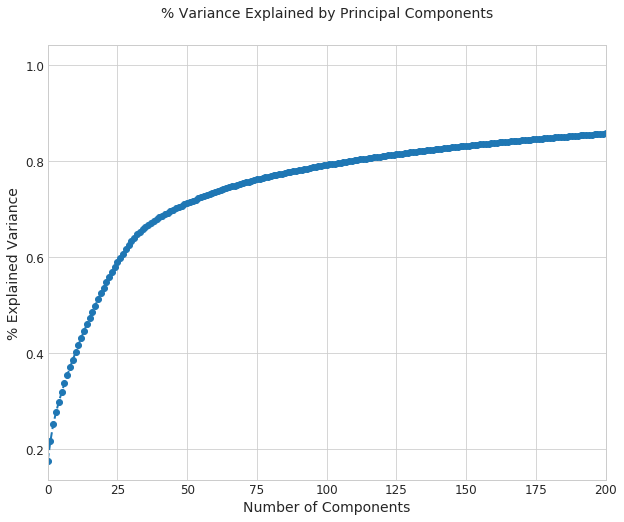

In [51]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [52]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0]

array([ 109,  110,  111, ..., 2847, 2848, 2849])

In [53]:
pca=PCA(n_components=109,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 109 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 109 components is: 0.799678386666


In [54]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [55]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,109).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.948392441938
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31838    54    31892
True        1877  3648     5525
__all__    33715  3702    37417

Accuracy of the model for test data is: 0.937780628608
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7966    19     7985
True         563   806     1369
__all__     8529   825     9354



Logistic Regression
Accuracy of the model for training data is: 0.951679717775
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31452   440    31892
True        1368  4157     5525
__all__    32820  4597    37417

Accuracy of the model for test data is: 0.952533675433
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7870   115     7985
True         329  1040     1369
__all__     8199  1155     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994040142181
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31889     3    31892
True         220  5305     5525
__all__    32109  5308    37417

Accuracy of the model for test data is: 0.944729527475
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7903    82     7985
True         435   934     1369
__all__     8338  1016     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.939065130823
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31348   544    31892
True        1736  3789     5525
__all__    33084  4333    37417

Accuracy of the model for test data is: 0.934680350652
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7827   158     7985
True         453   916     1369
__all__     8280  1074     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.953309992784
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31617   275    31892
True        1472  4053     5525
__all__    33089  4328    37417

Accuracy of the model for test data is: 0.949112679068
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7896    89     7985
True         387   982     1369
__all__     8283  1071     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.934252726106
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7923    62     7985
True         553   816     1369
__all__     8476   878     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993131464308
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31886     6    31892
True         251  5274     5525
__all__    32137  5280    37417

Accuracy of the model for test data is: 0.94815052384
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7898    87     7985
True         398   971     1369
__all__     8296  1058     9354



Neural Network-1
The accuracy of the model on training data is: 0.998930967207


Predicted  False  True  __all__
Actual                         
False      31883     9    31892
True          31  5494     5525
__all__    31914  5503    37417

The accuracy of the model on test data is: 0.952854393842


Predicted  False  True  __all__
Actual                         
False       7797   188     7985
True         253  1116     1369
__all__     8050  1304     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [56]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [57]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.948392,3648.0,31838.0,54.0,1877.0,0.001693,0.339729
LogisticRegression,0.951680,4157.0,31452.0,440.0,1368.0,0.013797,0.247602
RandomForestClassifier,0.994040,5305.0,31889.0,3.0,220.0,0.000094,0.039819
AdaBoostClassifier,0.939065,3789.0,31348.0,544.0,1736.0,0.017058,0.314208
GradientBoostingClassifier,0.953310,4053.0,31617.0,275.0,1472.0,0.008623,0.266425
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993131,5274.0,31886.0,6.0,251.0,0.000188,0.045430
Neural Network-1,0.998931,5494.0,31883.0,9.0,31.0,0.000282,0.005611


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.937781,806.0,7966.0,19.0,563.0,0.002379,0.411249,0.793186,0.730863
LogisticRegression,0.952534,1040.0,7870.0,115.0,329.0,0.014402,0.240321,0.872638,0.800728
RandomForestClassifier,0.944730,934.0,7903.0,82.0,435.0,0.010269,0.317750,0.835990,0.763340
AdaBoostClassifier,0.934680,916.0,7827.0,158.0,453.0,0.019787,0.330898,0.824657,0.719908
GradientBoostingClassifier,0.949113,982.0,7896.0,89.0,387.0,0.011146,0.282688,0.853083,0.783894
ExtraTreeClassifier,0.934253,816.0,7923.0,62.0,553.0,0.007765,0.403944,0.794145,0.712999
BaggingClassifier,0.948151,971.0,7898.0,87.0,398.0,0.010895,0.290723,0.849191,0.779390
Neural Network-1,0.952854,1116.0,7797.0,188.0,253.0,0.023544,0.184806,0.849191,0.807859


In [58]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')